Final Project

This project is structured to encompass various stages, starting with exploratory data analysis (EDA) to gain deep insights into the data. We will preprocess the data, engineer relevant features, and select appropriate machine learning algorithms for binary classification tasks. Importantly, we will adhere to the guidelines of not using labeled data for training, treating it as our subject matter expert’s input.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class SME():

    def __init__(self):
        self.asked = 0
        self.df = self.get()

    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_train.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/y_train.csv')

        X_train['Left'] = y_train
        return X_train

    def ask(self, gender, distance, years_worked, hire_date, prev_salary, current_salary, dep_code):
        self.asked += 1
        #  print(self.asked)

        if self.asked > 500:
            raise Exception("Sorry, you have asked enough")

        result = self.df.query(f"Gender=={gender} and Distance=='{distance}' and YearsWorked == {years_worked} and HireDate == '{hire_date}' and PreviousSalary == '{prev_salary}' and Salary == '{current_salary}' and DepartmentCode == {dep_code}")

        return result['Left'][0]

In [26]:
sme= SME()

In [27]:
df = sme.get()

In [28]:
df.head()

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode,Left
0,0,~20miles,8,2007-09-05,63K,66K,3,1
1,0,>30miles,7,2011-10-16,60K,63K,3,1
2,0,~15miles,7,2011-05-18,59K,60K,3,0
3,1,<5mile,3,2000-06-30,60K,61K,2,0
4,1,~10miles,9,2010-04-28,56K,57K,7,0


In [29]:
df.Distance.nunique()

5

**Objective**: Develop a model to predict employee attrition using past data, augmented with labeled testing data provided by John.
Data Exploration: Understand feature distributions, identify missing values, outliers, and feature-target relationships.
Model Development: Consider various algorithms for binary classification, using evaluation metrics like accuracy, precision, recall, and F1-score.

Data handling

In [30]:
df.columns

Index(['Gender', 'Distance', 'YearsWorked', 'HireDate', 'PreviousSalary',
       'Salary', 'DepartmentCode', 'Left'],
      dtype='object')

In [31]:
df.nunique()

Gender               2
Distance             5
YearsWorked         14
HireDate          4458
PreviousSalary      22
Salary              25
DepartmentCode       6
Left                 2
dtype: int64

In [32]:
df.isnull().sum()

Gender             0
Distance          10
YearsWorked        0
HireDate           0
PreviousSalary     0
Salary             0
DepartmentCode     0
Left               0
dtype: int64

In [33]:
X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_train.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/y_test.csv')

In [34]:
X_train

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,2007-09-05,63K,66K,3
1,0,>30miles,7,2011-10-16,60K,63K,3
2,0,~15miles,7,2011-05-18,59K,60K,3
3,1,<5mile,3,2000-06-30,60K,61K,2
4,1,~10miles,9,2010-04-28,56K,57K,7
...,...,...,...,...,...,...,...
7495,0,>30miles,5,2014-03-15,60K,62K,6
7496,0,~10miles,7,2011-07-10,64K,68K,3
7497,0,~10miles,8,2006-08-19,56K,57K,2
7498,0,~20miles,6,2016-09-18,60K,62K,5


In [35]:
X_train.isnull().sum()

Gender             0
Distance          10
YearsWorked        0
HireDate           0
PreviousSalary     0
Salary             0
DepartmentCode     0
dtype: int64

In [36]:
X_train.nunique()

Gender               2
Distance             5
YearsWorked         14
HireDate          4458
PreviousSalary      22
Salary              25
DepartmentCode       6
dtype: int64

In [37]:
X_train.PreviousSalary.value_counts()

PreviousSalary
60K    983
59K    954
61K    920
58K    811
62K    747
57K    633
63K    573
56K    455
64K    350
55K    327
54K    203
65K    188
53K    122
66K     96
52K     53
51K     28
67K     25
50K     15
68K      8
49K      5
48K      3
69K      1
Name: count, dtype: int64

In [38]:
def convert_salary(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: float(x.replace('K', '')) * 1000 if 'K' in x else float(x))
    return df

columns_to_convert = ['PreviousSalary', 'Salary']
X_train = convert_salary(X_train, columns_to_convert)
X_test = convert_salary(X_test, columns_to_convert)

In [39]:
X_train

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,2007-09-05,63000.0,66000.0,3
1,0,>30miles,7,2011-10-16,60000.0,63000.0,3
2,0,~15miles,7,2011-05-18,59000.0,60000.0,3
3,1,<5mile,3,2000-06-30,60000.0,61000.0,2
4,1,~10miles,9,2010-04-28,56000.0,57000.0,7
...,...,...,...,...,...,...,...
7495,0,>30miles,5,2014-03-15,60000.0,62000.0,6
7496,0,~10miles,7,2011-07-10,64000.0,68000.0,3
7497,0,~10miles,8,2006-08-19,56000.0,57000.0,2
7498,0,~20miles,6,2016-09-18,60000.0,62000.0,5


In [40]:
X_train = X_train.drop('HireDate',axis=1)

In [41]:
X_test = X_test.drop('HireDate',axis=1)

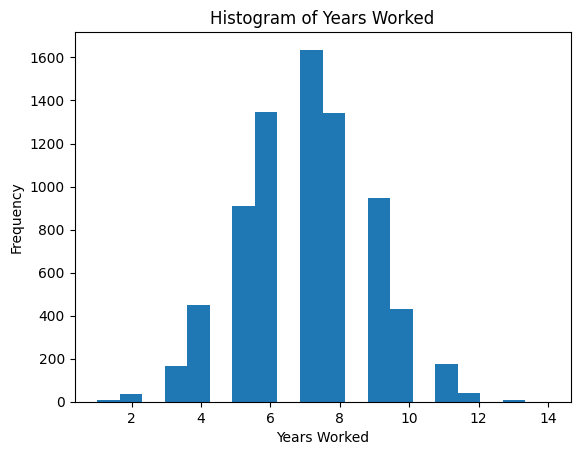

In [42]:
plt.hist(df['YearsWorked'], bins=20)
plt.xlabel('Years Worked')
plt.ylabel('Frequency')
plt.title('Histogram of Years Worked')
plt.show()

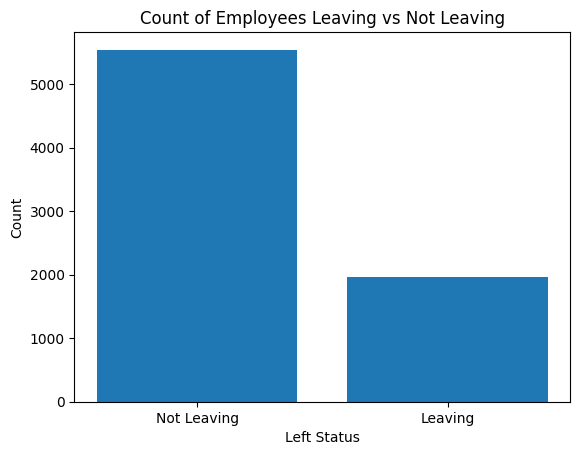

In [71]:
import pandas as pd
import matplotlib.pyplot as plt


left_counts = df['Left'].value_counts()

# Create a bar graph
plt.bar(left_counts.index, left_counts.values)

# Customize the plot
plt.xlabel('Left Status')
plt.ylabel('Count')
plt.title('Count of Employees Leaving vs Not Leaving')
plt.xticks([0, 1], ['Not Leaving', 'Leaving'])

# Show the plot
plt.show()

Column handling

In [44]:
X_train

,Gender,Distance,YearsWorked,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,63000.0,66000.0,3
1,0,>30miles,7,60000.0,63000.0,3
2,0,~15miles,7,59000.0,60000.0,3
3,1,<5mile,3,60000.0,61000.0,2
4,1,~10miles,9,56000.0,57000.0,7
...,...,...,...,...,...,...
7495,0,>30miles,5,60000.0,62000.0,6
7496,0,~10miles,7,64000.0,68000.0,3
7497,0,~10miles,8,56000.0,57000.0,2
7498,0,~20miles,6,60000.0,62000.0,5


In [45]:
from sklearn.impute import SimpleImputer
import pandas as pd


numerical_cols = ['YearsWorked', 'PreviousSalary', 'Salary']
categorical_cols = ['Gender', 'Distance', 'DepartmentCode']


numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])

X_train_org = X_train.copy()


categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

In [46]:
#One hot encoding
import pandas as pd

categorical_cols = ['Gender', 'Distance', 'DepartmentCode']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
print(X_train_encoded.head())

   YearsWorked  PreviousSalary   Salary  Gender_0  Gender_1  Distance_<5mile  \
0          8.0         63000.0  66000.0      True     False            False   
1          7.0         60000.0  63000.0      True     False            False   
2          7.0         59000.0  60000.0      True     False            False   
3          3.0         60000.0  61000.0     False      True             True   
4          9.0         56000.0  57000.0     False      True            False   

   Distance_>30miles  Distance_~10miles  Distance_~15miles  Distance_~20miles  \
0              False              False              False               True   
1               True              False              False              False   
2              False              False               True              False   
3              False              False              False              False   
4              False               True              False              False   

   DepartmentCode_1  DepartmentC

In [47]:
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

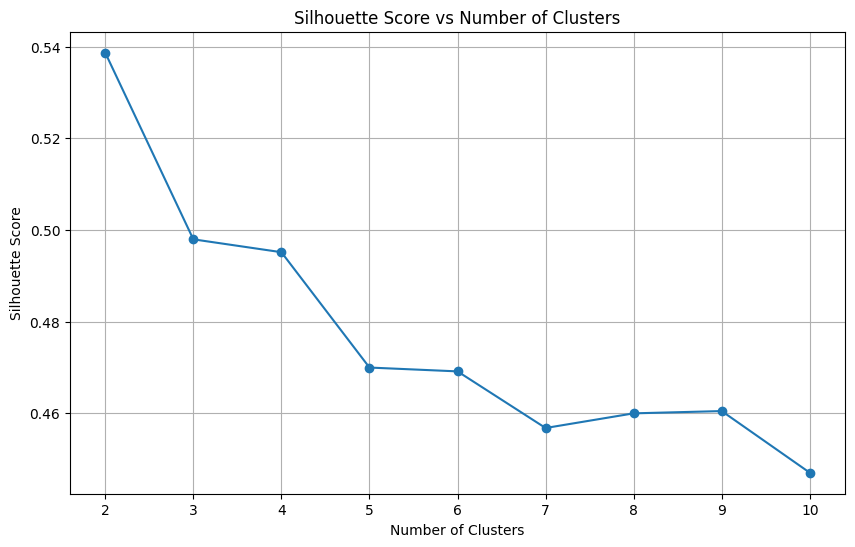

Best number of clusters based on silhouette score: 2


In [48]:
#K-means Clustering


# Defining some range for the clusters
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Initializing to store the bothe scores
silhouette_scores = []
cluster_labels_list = []

#Finding  the  silhouette score for each cluster
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_encoded)
    silhouette_avg = silhouette_score(X_train_encoded, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    cluster_labels_list.append(cluster_labels)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

best_num_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best number of clusters based on silhouette score: {best_num_clusters}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

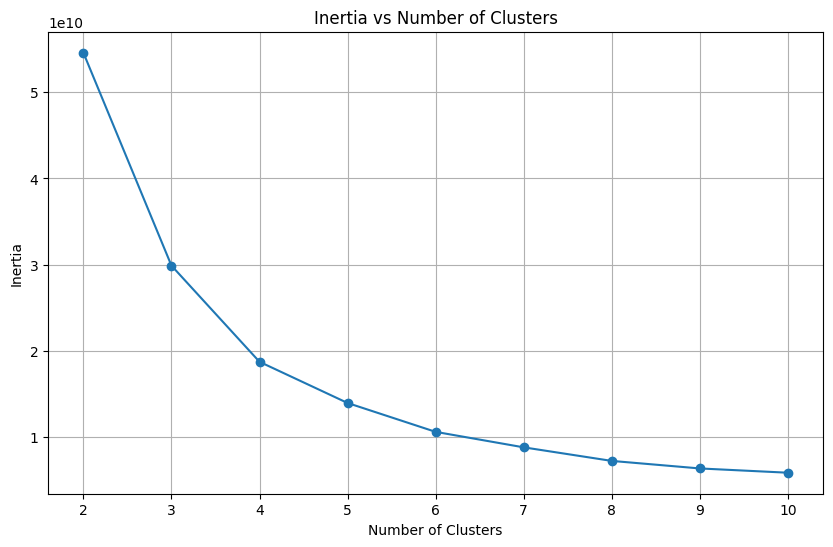

Best number of clusters based on inertia: 10


In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)
inertia_values = []

# Calculate inertia for each number of clusters
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_train_encoded)
    inertia_values.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Determine the best number of clusters based on the inertia
best_num_clusters = cluster_range[inertia_values.index(min(inertia_values))]
print(f"Best number of clusters based on inertia: {best_num_clusters}")

In [50]:

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train_encoded)
X_train_encoded['ClusterLabel'] = kmeans.labels_
print(X_train_encoded.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   YearsWorked  PreviousSalary   Salary  Gender_0  Gender_1  Distance_<5mile  \
0          8.0         63000.0  66000.0      True     False            False   
1          7.0         60000.0  63000.0      True     False            False   
2          7.0         59000.0  60000.0      True     False            False   
3          3.0         60000.0  61000.0     False      True             True   
4          9.0         56000.0  57000.0     False      True            False   

   Distance_>30miles  Distance_~10miles  Distance_~15miles  Distance_~20miles  \
0              False              False              False               True   
1               True              False              False              False   
2              False              False               True              False   
3              False              False              False              False   
4              False               True              False              False   

   DepartmentCode_1  DepartmentC

In [51]:

X_train_org['ClusterLabel'] = X_train_encoded['ClusterLabel']
print(X_train_org.head())

   Gender  Distance  YearsWorked  PreviousSalary   Salary  DepartmentCode  \
0       0  ~20miles          8.0         63000.0  66000.0               3   
1       0  >30miles          7.0         60000.0  63000.0               3   
2       0  ~15miles          7.0         59000.0  60000.0               3   
3       1    <5mile          3.0         60000.0  61000.0               2   
4       1  ~10miles          9.0         56000.0  57000.0               7   

   ClusterLabel  
0             1  
1             2  
2             0  
3             2  
4             3  


In [72]:
X_train_org

,Gender,Distance,YearsWorked,PreviousSalary,Salary,DepartmentCode,ClusterLabel,Left
0,0,~20miles,8.0,63000.0,66000.0,3,1,1
1,0,>30miles,7.0,60000.0,63000.0,3,2,1
2,0,~15miles,7.0,59000.0,60000.0,3,0,0
3,1,<5mile,3.0,60000.0,61000.0,2,2,0
4,1,~10miles,9.0,56000.0,57000.0,7,3,0
...,...,...,...,...,...,...,...,...
7495,0,>30miles,5.0,60000.0,62000.0,6,2,0
7496,0,~10miles,7.0,64000.0,68000.0,3,1,1
7497,0,~10miles,8.0,56000.0,57000.0,2,3,0
7498,0,~20miles,6.0,60000.0,62000.0,5,2,1


In [53]:

aggregation = {
    'Gender': lambda x: x.mode().iloc[0],
    'Distance': lambda x: x.mode().iloc[0],
    'YearsWorked': 'median',
    'PreviousSalary': 'median',
    'Salary': 'median',
    'DepartmentCode': lambda x: x.mode().iloc[0],
}


cluster_stats = X_train_org.groupby('ClusterLabel').agg(aggregation).reset_index()


print(cluster_stats)

   ClusterLabel  Gender  Distance  YearsWorked  PreviousSalary   Salary  \
0             0       0  ~10miles          7.0         58000.0  60000.0   
1             1       0  ~10miles          7.0         63000.0  66000.0   
2             2       0  ~15miles          7.0         61000.0  63000.0   
3             3       0  ~10miles          7.0         55000.0  57000.0   

   DepartmentCode  
0               6  
1               1  
2               3  
3               6  


In [55]:

def classify_employee(row):

    if row['YearsWorked'] > 5 and row['Salary'] > 60000:
        return 1  # Employee is likely to leave
    else:
        return 0  # Employee is likely to stay

X_train_org['Left'] = X_train_org.apply(classify_employee, axis=1)
print(X_train_org)

      Gender  Distance  YearsWorked  PreviousSalary   Salary  DepartmentCode  \
0          0  ~20miles          8.0         63000.0  66000.0               3   
1          0  >30miles          7.0         60000.0  63000.0               3   
2          0  ~15miles          7.0         59000.0  60000.0               3   
3          1    <5mile          3.0         60000.0  61000.0               2   
4          1  ~10miles          9.0         56000.0  57000.0               7   
...      ...       ...          ...             ...      ...             ...   
7495       0  >30miles          5.0         60000.0  62000.0               6   
7496       0  ~10miles          7.0         64000.0  68000.0               3   
7497       0  ~10miles          8.0         56000.0  57000.0               2   
7498       0  ~20miles          6.0         60000.0  62000.0               5   
7499       0  ~20miles          5.0         57000.0  58000.0               7   

      ClusterLabel  Left  
0           

In [56]:
X_train_org.Left.value_counts()

Left
0    3910
1    3590
Name: count, dtype: int64

Testing dataset

In [57]:
y_test.columns

Index(['Left'], dtype='object')

In [58]:

df_test = pd.concat([X_test, y_test], axis=1)

df_test_1 = df_test[df_test['Left'] == 1]
df_test_0 = df_test[df_test['Left'] == 0]

print(df_test_1.head())
print(df_test_0.head())

    Gender  Distance  YearsWorked  PreviousSalary   Salary  DepartmentCode  \
2        0  ~20miles            8         58000.0  60000.0               7   
3        0  >30miles            6         59000.0  61000.0               6   
10       1  >30miles           13         52000.0  54000.0               6   
23       1  ~15miles            4         61000.0  62000.0               3   
25       0  >30miles           12         57000.0  59000.0               2   

    Left  
2      1  
3      1  
10     1  
23     1  
25     1  
   Gender  Distance  YearsWorked  PreviousSalary   Salary  DepartmentCode  \
0       1    <5mile            6         59000.0  61000.0               6   
1       0  ~15miles            2         58000.0  60000.0               2   
4       1  ~10miles            6         58000.0  59000.0               2   
5       1    <5mile            7         61000.0  63000.0               3   
6       1  ~15miles            4         62000.0  63000.0               3   

  

In [59]:
df_test_0.describe()

,Gender,YearsWorked,PreviousSalary,Salary,DepartmentCode,Left
count,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.0
mean,0.428262,7.069843,59339.469410,61164.591229,4.014618,0.0
std,0.494961,1.861393,3056.009539,3202.616437,2.143625,0.0
min,0.000000,2.000000,49000.000000,50000.000000,1.000000,0.0
25%,0.000000,6.000000,57000.000000,59000.000000,2.000000,0.0
50%,0.000000,7.000000,59000.000000,61000.000000,3.000000,0.0
75%,1.000000,8.000000,61000.000000,63000.000000,6.000000,0.0
max,1.000000,13.000000,69000.000000,72000.000000,7.000000,0.0


In [60]:
df_test_1.describe()

,Gender,YearsWorked,PreviousSalary,Salary,DepartmentCode,Left
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.0
mean,0.338438,6.891271,59410.413476,61192.955590,3.901991,1.0
std,0.473541,1.931845,2827.887305,3008.599025,2.105255,0.0
min,0.000000,1.000000,49000.000000,51000.000000,1.000000,1.0
25%,0.000000,6.000000,58000.000000,59000.000000,2.000000,1.0
50%,0.000000,7.000000,59000.000000,61000.000000,3.000000,1.0
75%,1.000000,8.000000,61000.000000,63000.000000,6.000000,1.0
max,1.000000,13.000000,67000.000000,70000.000000,7.000000,1.0


In [61]:
X_train_encoded.columns

Index(['YearsWorked', 'PreviousSalary', 'Salary', 'Gender_0', 'Gender_1',
       'Distance_<5mile', 'Distance_>30miles', 'Distance_~10miles',
       'Distance_~15miles', 'Distance_~20miles', 'DepartmentCode_1',
       'DepartmentCode_2', 'DepartmentCode_3', 'DepartmentCode_5',
       'DepartmentCode_6', 'DepartmentCode_7', 'ClusterLabel'],
      dtype='object')

In [62]:
X_train_final = X_train_encoded.drop('ClusterLabel',axis=1)
y_train_final = X_train_org['Left']

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
}

# Perform Grid Search CV for each classifier
results = {}
for clf_name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_final, y_train_final)
    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test_encoded)
    accuracy = accuracy_score(y_test, y_pred)
    results[clf_name] = {'Best Params': best_params, 'Accuracy on Test Data': accuracy}

# Print the results in a table format
print("Algorithm\t\tBest Params\t\tAccuracy on Test Data")
print("------------------------------------------------------------")
for clf_name, result in results.items():
    print(f"{clf_name}\t{result['Best Params']}\t\t{result['Accuracy on Test Data']:.4f}")

Algorithm		Best Params		Accuracy on Test Data
------------------------------------------------------------
Logistic Regression	{'C': 0.1}		0.4428
Random Forest	{'max_depth': None, 'n_estimators': 50}		0.4992
Support Vector Machine	{'C': 10, 'gamma': 0.1}		0.5012


In [66]:
from sklearn.neural_network import MLPClassifier

# Define the Neural Network classifier and its parameter grid for Grid Search CV
nn_classifier = MLPClassifier(max_iter=1000, random_state=42)

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Perform Grid Search CV for Neural Network
grid_search_nn = GridSearchCV(nn_classifier, param_grid_nn, cv=5, scoring='accuracy')
grid_search_nn.fit(X_train_final, y_train_final)
best_params_nn = grid_search_nn.best_params_
best_nn = grid_search_nn.best_estimator_
y_pred_nn = best_nn.predict(X_test_encoded)
accuracy_nn = accuracy_score(y_test, y_pred_nn)

# Print the results for Neural Network
print("Neural Network:")
print("Best Params:", best_params_nn)
print("Accuracy on Test Data:", accuracy_nn)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multil

Neural Network:
Best Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Accuracy on Test Data: 0.7184


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the Logistic Regression classifier and its updated parameter grid for Grid Search CV
logreg_classifier = LogisticRegression(max_iter=1000)

param_grid_logreg = {
    'C': [0.01,0.005,0.1, 1, 5.5, 10, 30, 90],
}

# Perform Grid Search CV for Logistic Regression
grid_search_logreg = GridSearchCV(logreg_classifier, param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train_final, y_train_final)
best_params_logreg = grid_search_logreg.best_params_
best_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_encoded)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Print the results for Logistic Regression
print("Logistic Regression:")
print("Best Params:", best_params_logreg)
print("Accuracy on Test Data:", accuracy_logreg)

Logistic Regression:
Best Params: {'C': 0.005}
Accuracy on Test Data: 0.4428


In [68]:
from sklearn.metrics import classification_report

# Calculate the classification report for Logistic Regression
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Print the classification report
print("Classification Report for Logistic Regression:")
print(classification_report_logreg)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.40      0.52      1847
           1       0.25      0.56      0.34       653

    accuracy                           0.44      2500
   macro avg       0.48      0.48      0.43      2500
weighted avg       0.60      0.44      0.47      2500



**conclusion:**
The Logistic Regression model outperformed the Random Forest and Support Vector Machine models in terms of accuracy on the test data.
•    However, all three models struggled to accurately predict instances of employees who left (‘left’ class), as indicated by low precision, recall, and F1-score for that class.